In [ ]:
#### IMPORTANT NOTES
# It seems, in this case SVM won't work.
# If you found the better solution (in SVM too), please tell me.

In [48]:
#### Notebook identifier
%matplotlib notebook

In [49]:
#### Dependencies

from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from skimage.feature import greycomatrix, greycoprops

import glob
import math
import matplotlib.pyplot as plt
import os
import random
import statistics


In [50]:
#### Global variables

model = {}
test_model = {}
map_8bit_to_3bit = [i // 32 for i in range(256)]


In [76]:
#### Functions

def load_img(img_path):
    return Image.open(img_path).convert('L')

def get_img_size(img):
    return img.size

def print_img(img):
    plt.imshow(img, cmap='gray')
    
def get_resized_img(img, dimension):
    return img.resize(dimension)
    
def get_img_colors(img):
    return list(img.getdata())

def get_3bit_img_colors(img):
    img_colors = get_img_colors(img)
    
    loop_count = 0
    for img_color in img_colors:
        img_colors[loop_count] = map_8bit_to_3bit[img_color]
        
        loop_count += 1
        
    return img_colors

def get_img_matrix(img_colors):
    img_matrix = []
    
    loop_count = 0
    img_square_dimension = int(math.sqrt(len(img_colors)))
    
    for row in range(img_square_dimension):
        temp_row = []
        for col in range(img_square_dimension):
            temp_row.append(img_colors[loop_count])
            
            loop_count += 1
        img_matrix.append(temp_row)
        
    return img_matrix

def get_img_features(img):
    img_3bit_colors = get_3bit_img_colors(img)
    img_matrix = get_img_matrix(img_3bit_colors)
    
    glcm_matrix = greycomatrix(img_matrix, distances=[1], angles=[0], levels=12, symmetric=False, normed=False)
    glcm_components = ['contrast', 'correlation', 'energy', 'homogeneity', 'ASM', 'dissimilarity']
    
    img_features = []
    for glcm_component in glcm_components:
        img_features.append(greycoprops(glcm_matrix, glcm_component)[0][0])
        
    return tuple(img_features)

# Modelling

def init_model():
    global model
    global test_model
    
    model = {}
    test_model = {}
    
def get_class_names(training_path):
    return os.listdir(training_path)

def get_class_names_in_model():
    class_names = [class_name for class_name in model]
    
    return class_names

def add_class_names_to_model(class_names):
    global model
    global test_model
    
    for class_name in class_names:
        if(not class_name in model):
            model[class_name] = []
        if(not class_name in test_model):
            test_model[class_name] = []
            
def insert_img_features_into_model(class_name, img_features):
    global model
    
    if(class_name in model):
        model[class_name].append(img_features)
        
def insert_img_features_into_test_model(class_name, img_features):
    global test_model
    
    if(class_name in test_model):
        test_model[class_name].append(img_features)

def load_preprocessed_img(img_path, dimension=(128, 128)):
    img = load_img(img_path)
    img = get_resized_img(img, dimension)
    
    return img

def get_normalized_model(model):
    normalized_model = []
    
    for class_name in model:
        for glcm_values in model[class_name]:
            new_row = (class_name, glcm_values[0], glcm_values[1], glcm_values[2], glcm_values[3], glcm_values[4], glcm_values[5])
            normalized_model.append(new_row)
        
    return normalized_model
        
def train(training_path, training_rate=0.8, img_type='*.jpg'):
    print('Training...')
    class_names = get_class_names_in_model()
    for class_name in class_names:
        img_paths = glob.glob(training_path + class_name + '/' + img_type)
        
        for img_path in img_paths:
            random_splitter = random.uniform(0, 1)
            
            img = load_preprocessed_img(img_path)
            img_features = get_img_features(img)
            if(random_splitter <= training_rate):
                insert_img_features_into_model(class_name, img_features)
            else:
                insert_img_features_into_test_model(class_name, img_features)
            
    print('--> Done')
    
def get_single_glcm_feature(normalized_model, glcm_index):
    subset = []
    
    for row in normalized_model:
        subset.append(row[glcm_index])
        
    return subset

def get_hyperplane_coordinates(glcm_indexes):
    fig = plt.figure()
    plot = fig.add_subplot(111, projection='3d')
    colors = ['blue', 'red']
    
    x_points = []
    y_points = []
    z_points = []
    
    class_hyperplane_coordinates = []
    class_index = 0
    
    for class_name in model:
        splitted_glcm_feature_model = [get_single_glcm_feature(model[class_name], glcm_index) for glcm_index in glcm_indexes]
        model_x = [x + y for (x, y) in zip(splitted_glcm_feature_model[0], splitted_glcm_feature_model[1])]
        model_y = [x + y for (x, y) in zip(splitted_glcm_feature_model[2], splitted_glcm_feature_model[3])]
        model_z = [x + y for (x, y) in zip(splitted_glcm_feature_model[4], splitted_glcm_feature_model[5])]
        
        plot.scatter(model_x, model_y, model_z, 'o', c=colors[class_index])
        
        x_points.append((statistics.mean(model_x), max(model_x), min(model_x)))
        y_points.append((statistics.mean(model_y), max(model_y), min(model_y)))
        z_points.append((statistics.mean(model_z), max(model_z), min(model_z)))
        
        current_hyperplane_coordinates = [[x_points[class_index][1], y_points[class_index][-1], z_points[class_index][1]], [x_points[class_index][1], y_points[class_index][1], z_points[class_index][1]], [x_points[class_index][-1], y_points[class_index][1], z_points[class_index][-1]], [x_points[class_index][-1], y_points[class_index][-1], z_points[class_index][-1]]]
        current_hyperplane_coordinates.append(current_hyperplane_coordinates[0])
        class_hyperplane_coordinates.append(current_hyperplane_coordinates)
        
        current_hyperplane_x, current_hyperplane_y, current_hyperplane_z = zip(*current_hyperplane_coordinates)
        plot.plot3D(current_hyperplane_x, current_hyperplane_y, current_hyperplane_z)
        
        class_index += 1
        
    hyperplane_coordinates = [[(i + j)/2 for i, j in zip(x, y)] for x, y in zip(class_hyperplane_coordinates[0], class_hyperplane_coordinates[1])]
    hyperplane_x, hyperplane_y, hyperplane_z = zip(*hyperplane_coordinates)
    
    plot.plot3D(hyperplane_x, hyperplane_y, hyperplane_z, c='magenta')
    
    plot.set_xlabel('x')
    plot.set_xlabel('y')
    plot.set_xlabel('z')
    plt.show()
    
    return hyperplane_coordinates

def get_full_hyperplane_normal_equation(hyperplane_coordinates):
    #ref: https://www.geeksforgeeks.org/program-to-find-equation-of-a-plane-passing-through-3-points/
    #     https://stackoverflow.com/questions/15688232/check-which-side-of-a-plane-points-are-on
    
    p_coords = hyperplane_coordinates[0]
    q_coords = hyperplane_coordinates[2]
    r_coords = hyperplane_coordinates[1]
    
    pr_coords = ((r_coords[0] - p_coords[0]), (r_coords[1] - p_coords[1]), (r_coords[2] - p_coords[2]))
    pq_coords = ((q_coords[0] - p_coords[0]), (q_coords[1] - p_coords[1]), (q_coords[2] - p_coords[2]))
    
    hyperplane_normal_equation        = ((pr_coords[1] * pq_coords[2]) - (pq_coords[1] * pr_coords[2]), (pq_coords[0] * pr_coords[2]) - (pr_coords[0] * pq_coords[2]), (pr_coords[0] * pq_coords[1]) - (pr_coords[1] * pq_coords[0]))
    hyperplane_normal_equation_result = (hyperplane_normal_equation[0] * p_coords[0]) + (hyperplane_normal_equation[1] * p_coords[1]) + (hyperplane_normal_equation[2] * p_coords[2])

    return (hyperplane_normal_equation, hyperplane_normal_equation_result)

def get_packed_img_features(img_features, glcm_indexes):
    packed_img_features = [img_features[i] + img_features[i + 1] for i in range(0, 6, 2)]
    
    return packed_img_features

def get_img_features_class(img_features, full_hyperplane_normal_equation, glcm_indexes):
    (hyperplane_normal_equation, hyperplane_normal_equation_result) = full_hyperplane_normal_equation
    
    packed_img_features = get_packed_img_features(img_features, glcm_indexes)
    img_equation_result = 0
    for equation_index in range(3):
        img_equation_result += hyperplane_normal_equation[equation_index] * packed_img_features[equation_index]
        
    if(img_equation_result < hyperplane_normal_equation_result):
        img_class_name = 'tulis'
    else:
        img_class_name = 'cap'
        
    return img_class_name

def get_img_class(img, full_hyperplane_normal_equation, glcm_indexes):
    img_features = get_img_features(img)
    
    img_class_name = get_img_features_class(img_features, full_hyperplane_normal_equation, glcm_indexes)
        
    return img_class_name

def test(full_hyperplane_normal_equation, glcm_indexes):
    print('Testing...')
    class_names = get_class_names_in_model()
    total_correct_answer = 0
    total_guess = 0
    
    for class_name in test_model:
        for test_img_features in test_model[class_name]:
            test_img_class_name = get_img_features_class(test_img_features, full_hyperplane_normal_equation, glcm_indexes)
            
            if(class_name == test_img_class_name):
                total_correct_answer += 1
                
            total_guess += 1
    
    accuracy = (total_correct_answer / total_guess) * 100
    
    print('--> Done, accuracy = ' + str(accuracy) + ' %')
    
    return accuracy

def validate(validation_path, full_hyperplane_normal_equation, glcm_indexes, img_type='*.jpg'):
    print('Validating...')
    class_names = get_class_names_in_model()
    total_correct_answer = 0
    total_guess = 0
    
    for class_name in class_names:
        img_paths = glob.glob(validation_path + class_name + '/' + img_type)
        for img_path in img_paths:
            img = load_preprocessed_img(img_path)
            img_class_name = get_img_class(img, full_hyperplane_normal_equation, glcm_indexes)
            
            if(class_name == img_class_name):
                total_correct_answer += 1
                
            total_guess += 1
            
    print('--> Done')
    
    accuracy = (total_correct_answer / total_guess) * 100
    
    return accuracy


Epoch 1
Training...
--> Done


<IPython.core.display.Javascript object>


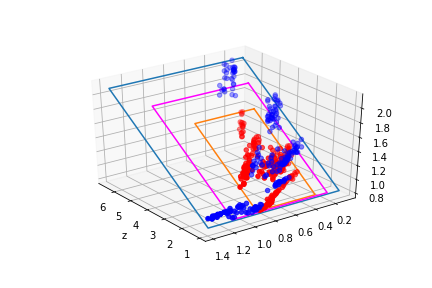

Testing...
--> Done, accuracy = 56.52173913043478 %

Epoch 2
Training...
--> Done


<IPython.core.display.Javascript object>


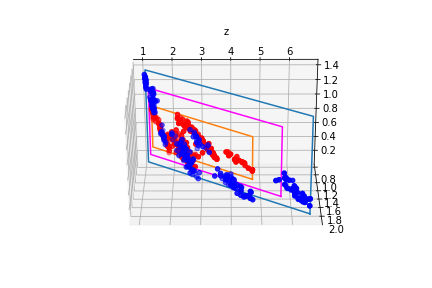

Testing...
--> Done, accuracy = 56.49999999999999 %

Epoch 3
Training...
--> Done


<IPython.core.display.Javascript object>


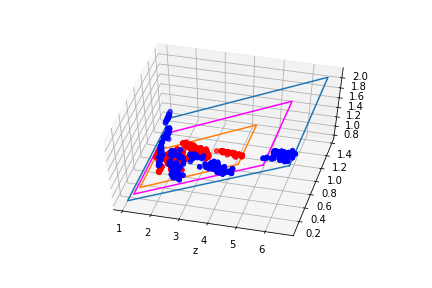

Testing...
--> Done, accuracy = 55.670103092783506 %

Epoch 4
Training...
--> Done


<IPython.core.display.Javascript object>


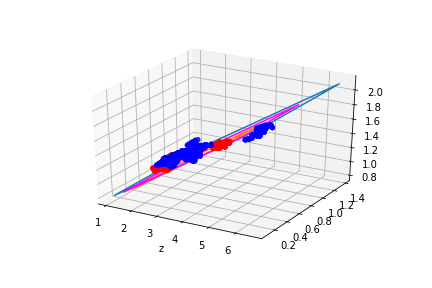

Testing...
--> Done, accuracy = 56.37755102040817 %

Epoch 5
Training...
--> Done


<IPython.core.display.Javascript object>


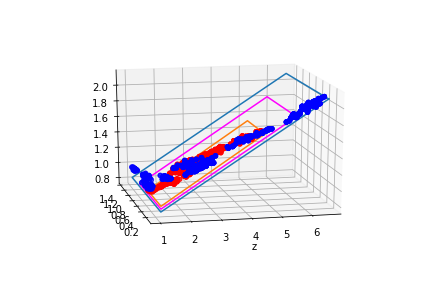

Testing...
--> Done, accuracy = 56.22489959839358 %

Validating...
--> Done
Accuracy: 58.984375 %


In [78]:
#### Main

# Defining paths
root_path       = './'
training_path   = root_path + 'training/'
validation_path = root_path + 'validation/'
test_path       = root_path + 'test/'

# Props
epochs = 5
training_rate = 0.8
img_type = '*.jpg'
glcm_indexes = [0, 3, 1, 4, 2, 5]

# Init
init_model()
class_names = get_class_names(training_path)
add_class_names_to_model(class_names)

for epoch in range(epochs):
    print('Epoch ' + str(epoch + 1))
    train(training_path, training_rate, img_type)
    hyperplane_coordinates = get_hyperplane_coordinates(glcm_indexes)
    full_hyperplane_normal_equation = get_full_hyperplane_normal_equation(hyperplane_coordinates)
    test(full_hyperplane_normal_equation, glcm_indexes)
    print()

accuracy = validate(validation_path, full_hyperplane_normal_equation, glcm_indexes, img_type)

print('Accuracy: ' + str(accuracy) + ' %')

In [81]:
img = load_img(test_path + 'cap.jpg')
print(get_img_class(img, full_hyperplane_normal_equation, glcm_indexes))
# test false

tulis


In [83]:
img = load_img(test_path + 'cap2.jpg')
print(get_img_class(img, full_hyperplane_normal_equation, glcm_indexes))
# test false

tulis


In [84]:
img = load_img(test_path + 'tulis.jpg')
print(get_img_class(img, full_hyperplane_normal_equation, glcm_indexes))
# test true

tulis
